In [1]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#read data under dataframe
train = pd.read_csv('/content/drive/My Drive/Deep Learning Data/Quora Duplicated Question/train.csv')
train.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [7]:
print("Total number of question pairs for training: {}".format(len(train)))

print("Percentage of duplicated question pair :{}%".format(round(len(train[train['is_duplicate']==1])/len(train)*100, 2)))

Total number of question pairs for training: 404290
Percentage of duplicated question pair :36.92%


Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780



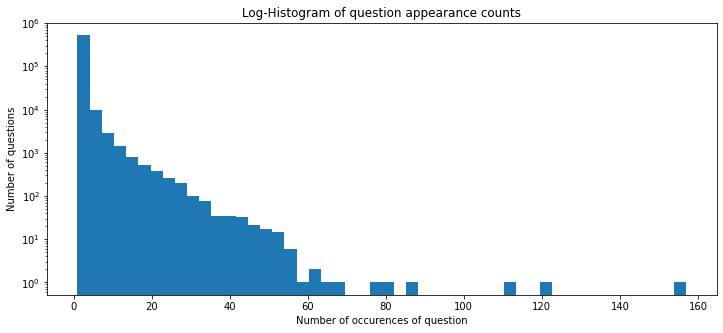

In [10]:
## So we have some kinds of class imbalance in this dataset

qids = pd.Series(train['qid1'].tolist() + train['qid2'].tolist())

print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

Text(0, 0.5, 'Counts')

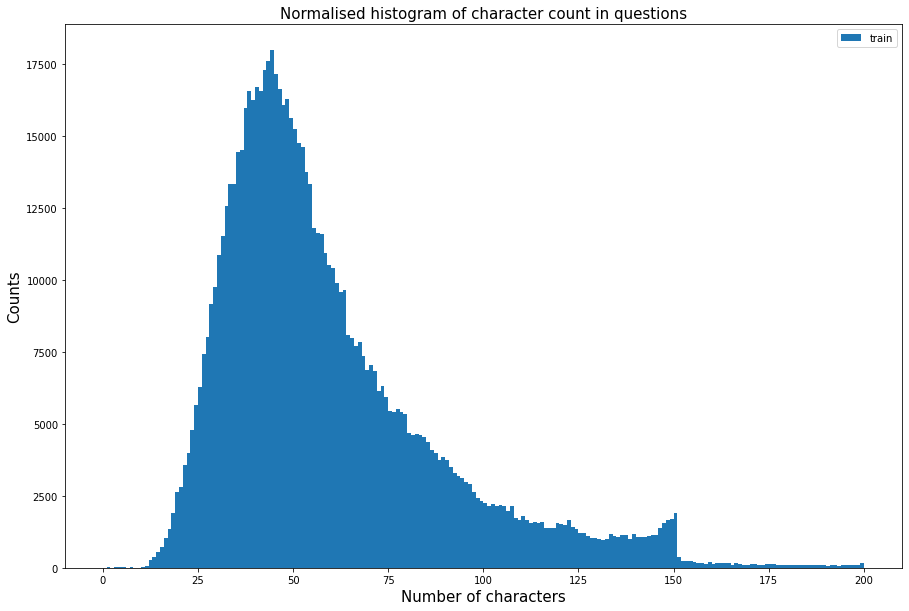

In [16]:
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200],  label='train')

plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Counts', fontsize=15)


In [20]:
# Text Preprocessing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
stops= set(stopwords.words('english'))

Text(0.5, 0, 'word_match_share')

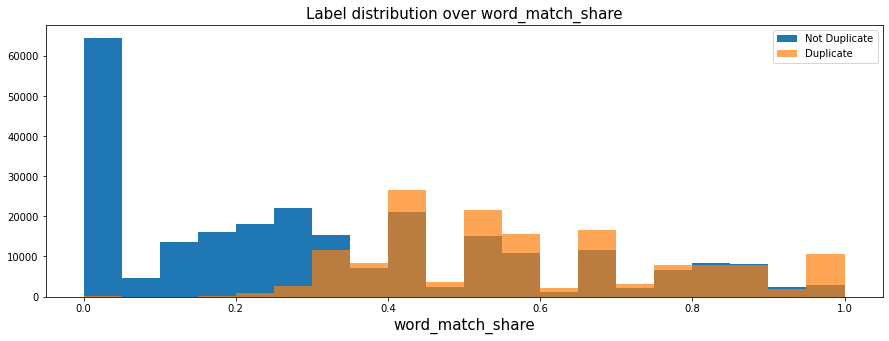

In [26]:
### A pair of similar questions should have more words shared than an non-duplicated pair. So, first, we should take  alook at how number of words shared between each pair
## However, some of the 
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[train['is_duplicate'] == 0], bins=20,  label='Not Duplicate')
plt.hist(train_word_match[train['is_duplicate'] == 1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [0]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [0]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5, 0, 'word_match_share')

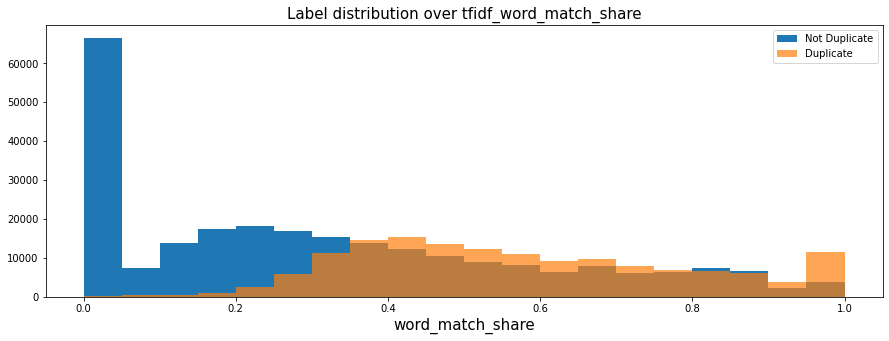

In [30]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = train.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[train['is_duplicate'] == 0].fillna(0), bins=20,  label='Not Duplicate')
plt.hist(tfidf_train_word_match[train['is_duplicate'] == 1].fillna(0), bins=20,  alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [0]:
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match

y_train = train['is_duplicate'].values


In [35]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19124366100096607


In [0]:
# Finally, we split some of the data off for validation
from sklearn.model_selection import train_test_split, GridSearchCV

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

In [38]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.683201	valid-logloss:0.683252
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.602145	valid-logloss:0.602636
[20]	train-logloss:0.545039	valid-logloss:0.545863
[30]	train-logloss:0.503375	valid-logloss:0.50444
[40]	train-logloss:0.47226	valid-logloss:0.473521
[50]	train-logloss:0.448638	valid-logloss:0.450059
[60]	train-logloss:0.430489	valid-logloss:0.432044
[70]	train-logloss:0.416379	valid-logloss:0.418048
[80]	train-logloss:0.405353	valid-logloss:0.407118
[90]	train-logloss:0.396699	valid-logloss:0.398544
[100]	train-logloss:0.389885	valid-logloss:0.391795
[110]	train-logloss:0.384474	valid-logloss:0.386436
[120]	train-logloss:0.380201	valid-logloss:0.382196
[130]	train-logloss:0.376799	valid-logloss:0.378823
[140]	train-logloss:0.374091	valid-logloss:0.376139
[150]	train-logloss:0.371912	valid-logloss:0.373981
[160]	train-logloss:0.370167	v

In [0]:
## Hyperparameters search for XGBoost, But i wont run this one since it takes forever to run with limited resource on Google Colab
model = xgb.XGBClassifier()
params ={'n_estimators':[10, 20, 50, 100, 200, 500, 1000, 2000], 'eta':[0.01, 0.02, 0.03, 0.04, 0.05 , 0.07, 0.09], 'gamma':[1, 5, 10, 100], 'max_depth':[4, 5, 6, 7, 8, 9], 
         'lambda' :[1, 5, 10, 20, 50], 'alpha':[0,1, 2, 5, 10, 50]}

In [0]:
#applying gridsearch CV to find best XGboost model. You can you similar approach and code for different models such as Naive Bayes, LR, SVM, KNN....
tune = GridSearchCV(model, params, cv = 10, scoring = 'roc_auc').fit(x_train, y_train)


In [47]:
best_parameters, score, _ = max(tune.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

NameError: ignored